In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Conv1D
from tensorflow.keras.optimizers import Adam

In [ ]:
# Function to load stock data
def load_data(stock, start_date, end_date):
    return yf.download(stock, start=start_date, end=end_date)[['Open', 'High', 'Low', 'Close', 'Volume']]

# Function to preprocess data for training
def preprocess_data(data, seq_length):
    # Scaling only the required columns
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[['Open', 'High', 'Low', 'Close']])
    x_train, y_train = [], []
    for i in range(seq_length, len(scaled_data)):
        x_train.append(scaled_data[i-seq_length:i, :-1])
        y_train.append(scaled_data[i, -1])
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 3))
    
    return scaled_data, x_train, y_train, scaler

# Create and compile the model
def create_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=100, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(LSTM(units=100, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
    return model

# Train the model
def train_model(x_train, y_train):
    model = create_model((x_train.shape[1], x_train.shape[2]))
    model.fit(x_train, y_train, batch_size=32, epochs=25)
    return model

# Create test data
def create_test_data(scaled_data, scaler, seq_length):
    test_data_unscaled = scaled_data[len(scaled_data) - seq_length:]
    test_data = scaler.transform(test_data_unscaled)
    x_test, y_test = [], []
    for i in range(seq_length, len(test_data)):
        x_test.append(test_data[i-seq_length:i, :-1])
        y_test.append(test_data[i, -1])
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 3))
    y_test = np.array(y_test)
    return x_test, y_test

# Make predictions
def make_predictions(model, x_test, scaler):
    prediction = model.predict(x_test)
    prediction_unscaled = np.concatenate((x_test[:, -1, :], prediction), axis=1)
    prediction_unscaled[:, -1] = prediction[:, 0]
    prediction = scaler.inverse_transform(prediction_unscaled)[:, -1]
    return prediction

# Plot the predictions
def plot_prediction(data, prediction, stock, seq_length):
    plt.figure(figsize=(15,6))
    plt.plot(data['Close'].values, color='blue', label='Actual Stock Price')
    plt.plot(range(seq_length, len(prediction) + seq_length), prediction, color='red', label='Predicted Stock Price')
    plt.title('Stock Price Prediction for ' + stock)
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()


# Moving Averages Analysis Function
def moving_averages(data, window_sizes=[5, 10, 20, 50]):
    ma_data = data.copy()
    for window in window_sizes:
        ma_data['MA' + str(window)] = data['Close'].rolling(window=window).mean()
    return ma_data

# Volume Analysis Function
def plot_volume(data):
    fig, ax1 = plt.subplots(figsize=(15, 6))
    ax2 = ax1.twinx()
    ax1.plot(data['Close'], color='blue')
    ax2.bar(data.index, data['Volume'], color='gray')
    ax1.set_title('Price and Volume')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price', color='blue')
    ax2.set_ylabel('Volume', color='gray')
    plt.show()

# Technical Indicators Analysis Function
# Technical Indicators Analysis Function without TA-Lib
def compute_technical_indicators(data):
    ti_data = data.copy()

    # RSI (Relative Strength Index)
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=14, min_periods=1).mean()
    avg_loss = loss.rolling(window=14, min_periods=1).mean()
    rs = avg_gain / avg_loss
    ti_data['RSI'] = 100 - (100 / (1 + rs))

    # MACD (Moving Average Convergence Divergence)
    exp1 = data['Close'].ewm(span=12, adjust=False).mean()
    exp2 = data['Close'].ewm(span=26, adjust=False).mean()
    ti_data['MACD'] = exp1 - exp2

    # Bollinger Bands
    rolling_mean = data['Close'].rolling(window=20).mean()
    rolling_std = data['Close'].rolling(window=20).std()
    ti_data['Bollinger_Upper'] = rolling_mean + (rolling_std * 2)
    ti_data['Bollinger_Middle'] = rolling_mean
    ti_data['Bollinger_Lower'] = rolling_mean - (rolling_std * 2)

    return ti_data


# Function to Plot Technical Indicators
def plot_technical_indicators(ti_data):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, figsize=(15, 12))
    ax1.plot(ti_data['Close'], label='Close Price')
    ax1.set_title('Technical Indicators')
    ax1.set_ylabel('Price')
    ax1.legend(loc='best')
    ax2.plot(ti_data['RSI'], label='RSI')
    ax2.set_ylabel('RSI')
    ax2.legend(loc='best')
    ax3.plot(ti_data['MACD'], label='MACD')
    ax3.set_ylabel('MACD')
    ax3.legend(loc='best')
    ax4.plot(ti_data['Bollinger_Upper'], label='Bollinger Upper')
    ax4.plot(ti_data['Bollinger_Middle'], label='Bollinger Middle')
    ax4.plot(ti_data['Bollinger_Lower'], label='Bollinger Lower')
    ax4.set_ylabel('Bollinger Bands')
    ax4.legend(loc='best')
    plt.show()


Please enter the stock symbol (e.g., AAPL for Apple Inc.):  TSLA


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Epoch 1/25
33/33 [==============================] - 12s 207ms/step - loss: 0.0764
Epoch 2/25
33/33 [==============================] - 7s 210ms/step - loss: 0.0043
Epoch 3/25
33/33 [==============================] - 7s 206ms/step - loss: 0.0028
Epoch 4/25
33/33 [==============================] - 7s 207ms/step - loss: 0.0023
Epoch 5/25
33/33 [==============================] - 7s 208ms/step - loss: 0.0020
Epoch 6/25
33/33 [==============================] - 7s 210ms/step - loss: 0.0020
Epoch 7/25
33/33 [==============================] - 7s 207ms/step - loss: 0.0018
Epoch 8/25
33/33 [==============================] - 7s 207ms/step - loss: 0.0020
Epoch 9/25
33/33 [==============================] - 7s 205ms/step - loss: 0.0017
Epoch 10/25
33/33 [==============================] - 7s 203ms/step - loss: 0.0016
Epoch 11/25
33/33 [==============================]

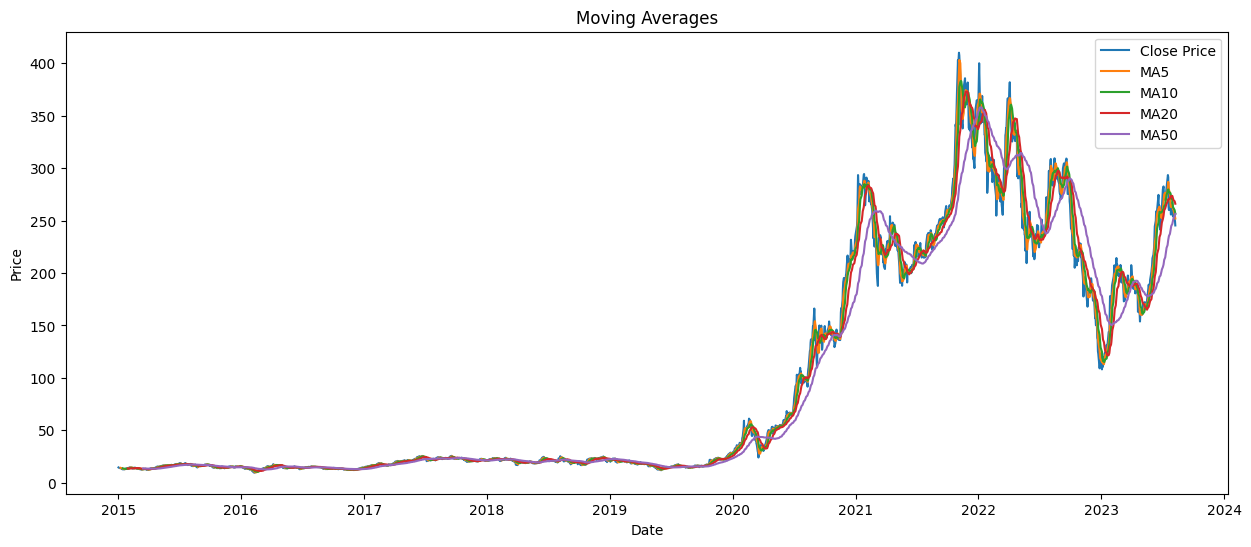

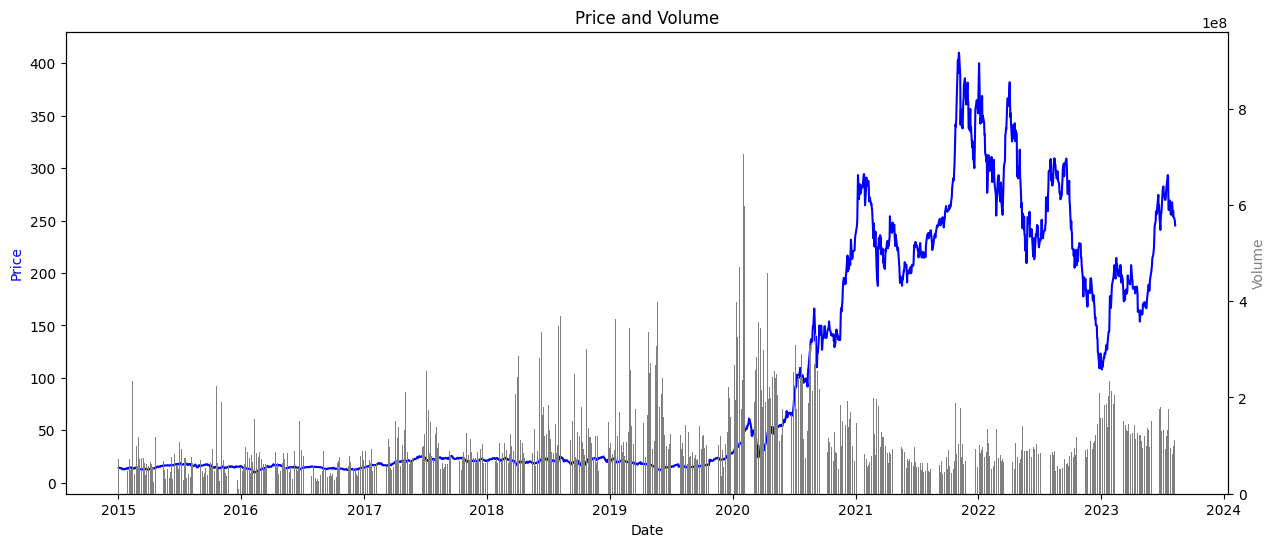

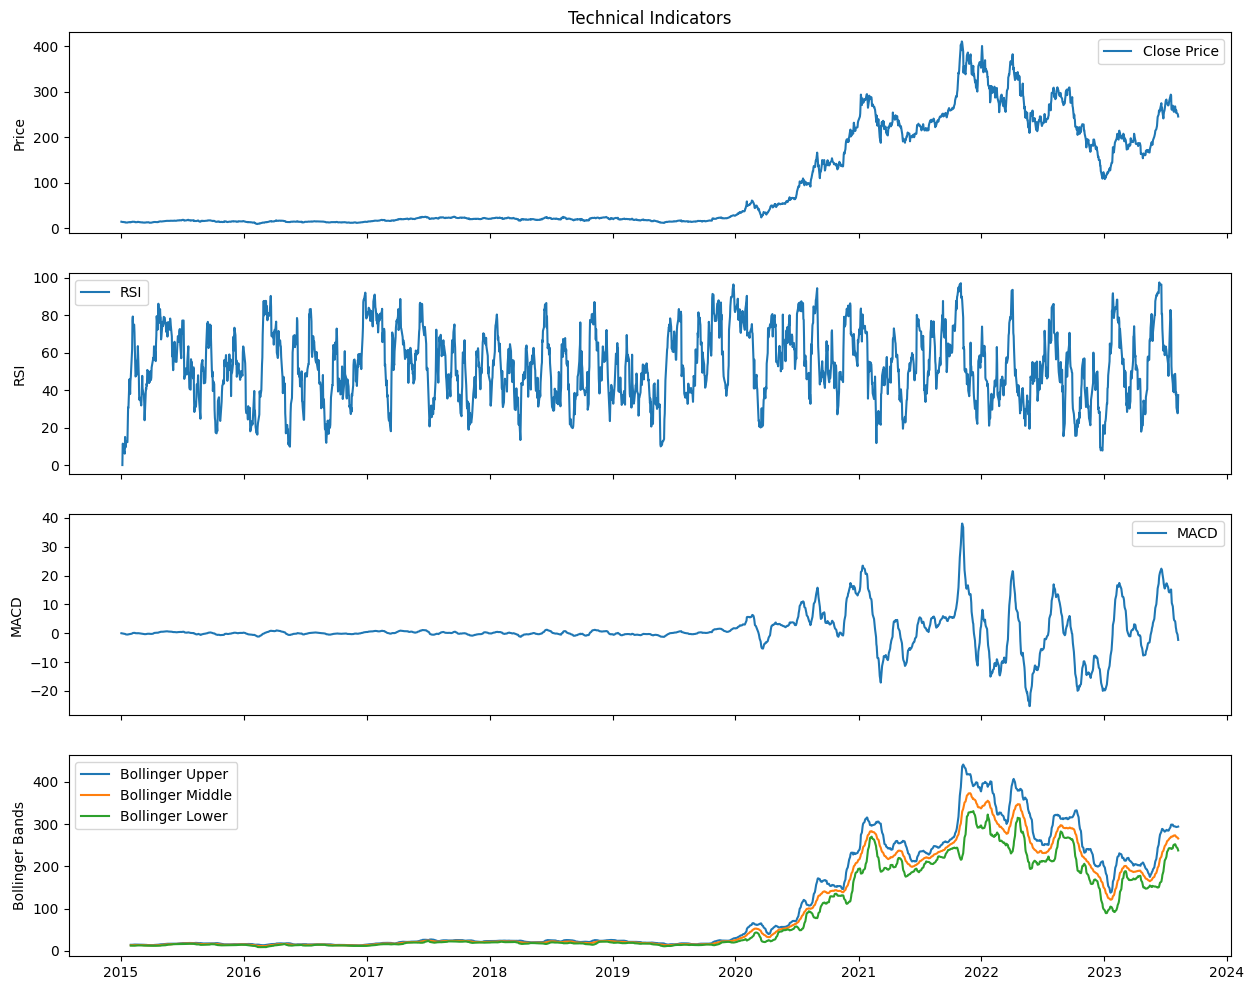

In [11]:
    stock = get_user_stock()
    start_date = '2015-01-01'
    end_date = '2023-12-31'
    seq_length = 60

    data = load_data(stock, start_date, end_date)
    data['Volume'] = yf.download(stock, start=start_date, end=end_date)['Volume']
    scaled_data, x_train, y_train, scaler = preprocess_data(data, seq_length)

    # K-Fold Cross-Validation
    kfold = KFold(n_splits=2, shuffle=True)
    for train_index, test_index in kfold.split(x_train):
        train_X, test_X = x_train[train_index], x_train[test_index]
        train_y, test_y = y_train[train_index], y_train[test_index]
        model = train_model(train_X, train_y)
        prediction = make_predictions(model, test_X, scaler)
        mse = mean_squared_error(test_y, prediction)
        print(f"Mean Squared Error for fold: {mse}")
        
    ma_data = moving_averages(data[['Close']])
    plt.figure(figsize=(15, 6))
    plt.plot(ma_data['Close'], label='Close Price')
    for col in ma_data.columns[1:]:
        plt.plot(ma_data[col], label=col)
    plt.title('Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    # Volume Analysis
    plot_volume(data)

    # Technical Indicators Analysis
    ti_data = compute_technical_indicators(data[['Close']])
    plot_technical_indicators(ti_data)

In [12]:
def backtest_model(data, seq_length, window_size='1M'):
    cumulative_profit = 0
    profits = []
    holding_stock = False
    buy_price = 0
    
    # Resampling the data by the window size (e.g., monthly)
    resampled_data = data.resample(window_size).agg({'Open': 'first', 
                                                    'High': 'max', 
                                                    'Low': 'min', 
                                                    'Close': 'last',
                                                    'Volume': 'sum'})
    
    for i in range(seq_length + 41, len(resampled_data) - 1):
        # Training Data

        scaled_data, x_train, y_train, scaler = preprocess_data(data, seq_length)
        model = train_model(x_train, y_train)
        ti_data = compute_technical_indicators(data)  # Assuming you have a function for this

        # Testing Data (One window forward)
        test_data = resampled_data.iloc[i:i+1]
        actual_price = test_data['Close'].iloc[0]
        rsi_value = ti_data['RSI'].iloc[i - (seq_length + 42)] # Getting the corresponding RSI value

        # Apply Buy/Sell strategy
        stop_loss_threshold = 0.05 # 5% loss
        take_profit_threshold = 0.05 # 5% profit

        # Buy condition: RSI below 30 and not holding stock
        if rsi_value < 30 and not holding_stock:
            buy_price = actual_price
            holding_stock = True

        # Sell condition: RSI above 70 and holding stock
        elif holding_stock and rsi_value > 70:
            profit = actual_price - buy_price
            cumulative_profit += profit
            profits.append(cumulative_profit)
            holding_stock = False
            
    # Reporting
    if profits and profits[-1] > 0: # Making sure there's profit to report
        plt.plot(profits)
        plt.title('Backtesting Cumulative Profits')
        plt.xlabel('Window')
        plt.ylabel('Profit')
        plt.show()

    return profits

profits = backtest_model(data, seq_length)
print("Backtesting Completed. Cumulative Profits:", profits)


Epoch 1/25
66/66 [==============================] - 16s 139ms/step - loss: 0.0587
Epoch 2/25
66/66 [==============================] - 9s 129ms/step - loss: 0.0022
Epoch 3/25
66/66 [==============================] - 9s 130ms/step - loss: 0.0020
Epoch 4/25
66/66 [==============================] - 8s 123ms/step - loss: 0.0015
Epoch 5/25
66/66 [==============================] - 8s 120ms/step - loss: 0.0014
Epoch 6/25
66/66 [==============================] - 8s 120ms/step - loss: 0.0012
Epoch 7/25
66/66 [==============================] - 8s 120ms/step - loss: 0.0012
Epoch 8/25
66/66 [==============================] - 8s 121ms/step - loss: 0.0015
Epoch 9/25
66/66 [==============================] - 8s 120ms/step - loss: 0.0011
Epoch 10/25
66/66 [==============================] - 8s 119ms/step - loss: 8.6102e-04
Epoch 11/25
66/66 [==============================] - 8s 124ms/step - loss: 0.0014
Epoch 12/25
66/66 [==============================] - 8s 121ms/step - loss: 0.0013
Epoch 13/25
66/66 [=

In [13]:
# Function to predict future prices and provide buy/sell recommendations
def future_price_predictions(model, scaler, last_data, seq_length, forecast_length=7):
    input_data = last_data[-seq_length:, :4].copy()  # Including only 'Open', 'High', 'Low', 'Close'
    future_prices = []
    # Predict future prices
    for _ in range(forecast_length):
        scaled_input = scaler.transform(input_data[-seq_length:])
        scaled_input = scaled_input[:, :-1].reshape((1, seq_length, 3))
        predicted_price = model.predict(scaled_input)[0][0]
        input_data = np.vstack([input_data, [predicted_price, 0, 0, 0]])
        unscaled_prediction = scaler.inverse_transform(
            np.append(scaled_input[0, -1, :], predicted_price).reshape(1, -1)
        )[-1, -1]
        future_prices.append(unscaled_prediction)



    # Determine best days to buy/sell
    buy_days = []
    sell_day = 0
    max_profit = 0

    for i in range(forecast_length):
        for j in range(i + 1, forecast_length):
            profit = future_prices[j] - future_prices[i]
            if profit > max_profit:
                max_profit = profit
                buy_days = [i]
                sell_day = j
            elif profit == max_profit:
                buy_days.append(i)

    # Create a table to display the results
    result_table = pd.DataFrame({
        'Day': [f"Day {i + 1}" for i in range(forecast_length)],
        'Predicted Price': future_prices,
        'Action': ['Buy' if i in buy_days else 'Sell' if i == sell_day else '' for i in range(forecast_length)]
    })

    return result_table

# Future Price Predictions and Buy/Sell Recommendations
recommendations = future_price_predictions(model, scaler, data.values, seq_length)
print("Future Price Predictions and Buy/Sell Recommendations:")
print(recommendations)

1/1 [==============================] - ETA: 0s

C:\Users\dev24\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\dev24\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\dev24\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\dev24\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 18ms/step
Future Price Predictions and Buy/Sell Recommendations:
     Day  Predicted Price Action
0  Day 1       262.915743       
1  Day 2       172.219173       
2  Day 3        77.363717       
3  Day 4        14.621139    Buy
4  Day 5        16.513896       
5  Day 6        52.854303       
6  Day 7        60.251446   Sell


C:\Users\dev24\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\dev24\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\dev24\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Please enter the stock symbol (e.g., AAPL for Apple Inc.):  GOOGL


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Epoch 1/25
53/53 [==============================] - 10s 85ms/step - loss: 0.0857
Epoch 2/25
53/53 [==============================] - 4s 84ms/step - loss: 0.0034
Epoch 3/25
53/53 [==============================] - 4s 84ms/step - loss: 0.0028
Epoch 4/25
53/53 [==============================] - 5s 89ms/step - loss: 0.0020
Epoch 5/25
53/53 [==============================] - 5s 86ms/step - loss: 0.0020
Epoch 6/25
53/53 [==============================] - 5s 90ms/step - loss: 0.0022
Epoch 7/25
53/53 [==============================] - 6s 115ms/step - loss: 0.0017
Epoch 8/25
53/53 [==============================] - 5s 98ms/step - loss: 0.0017
Epoch 9/25
53/53 [==============================] - 5s 88ms/step - loss: 0.0020
Epoch 10/25
53/53 [==============================] - 5s 88ms/step - loss: 0.0020
Epoch 11/25
53/53 [==============================] - 5s 90m

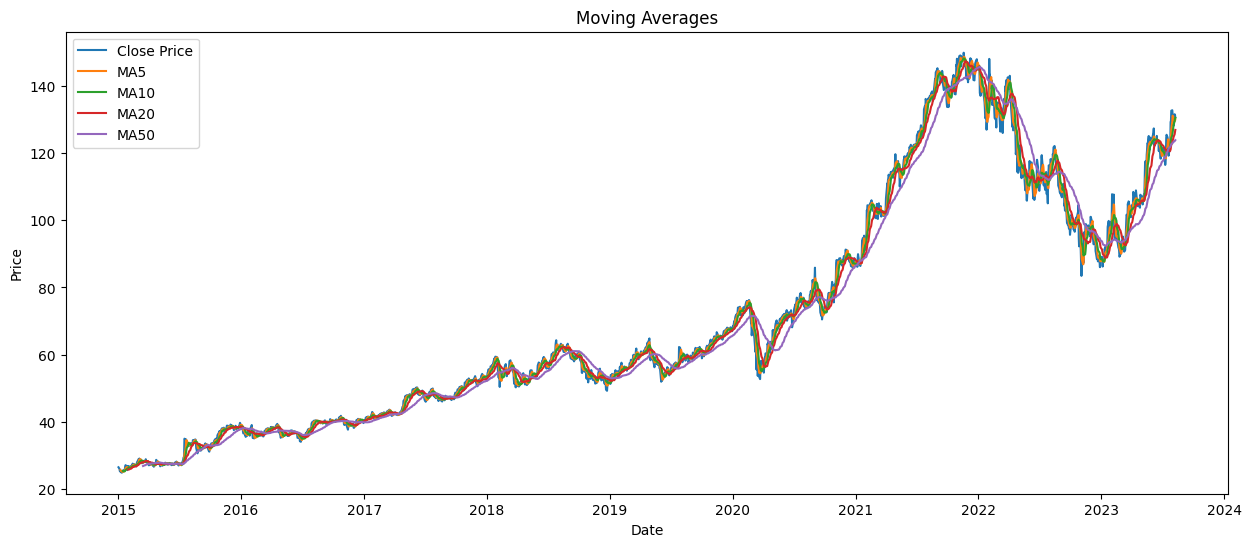

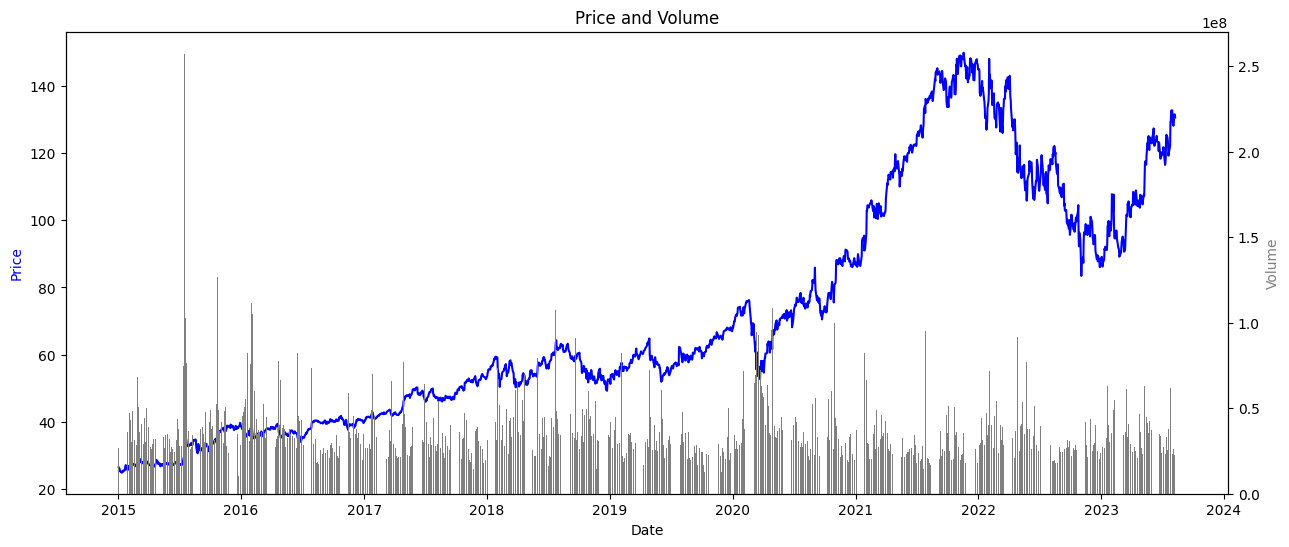

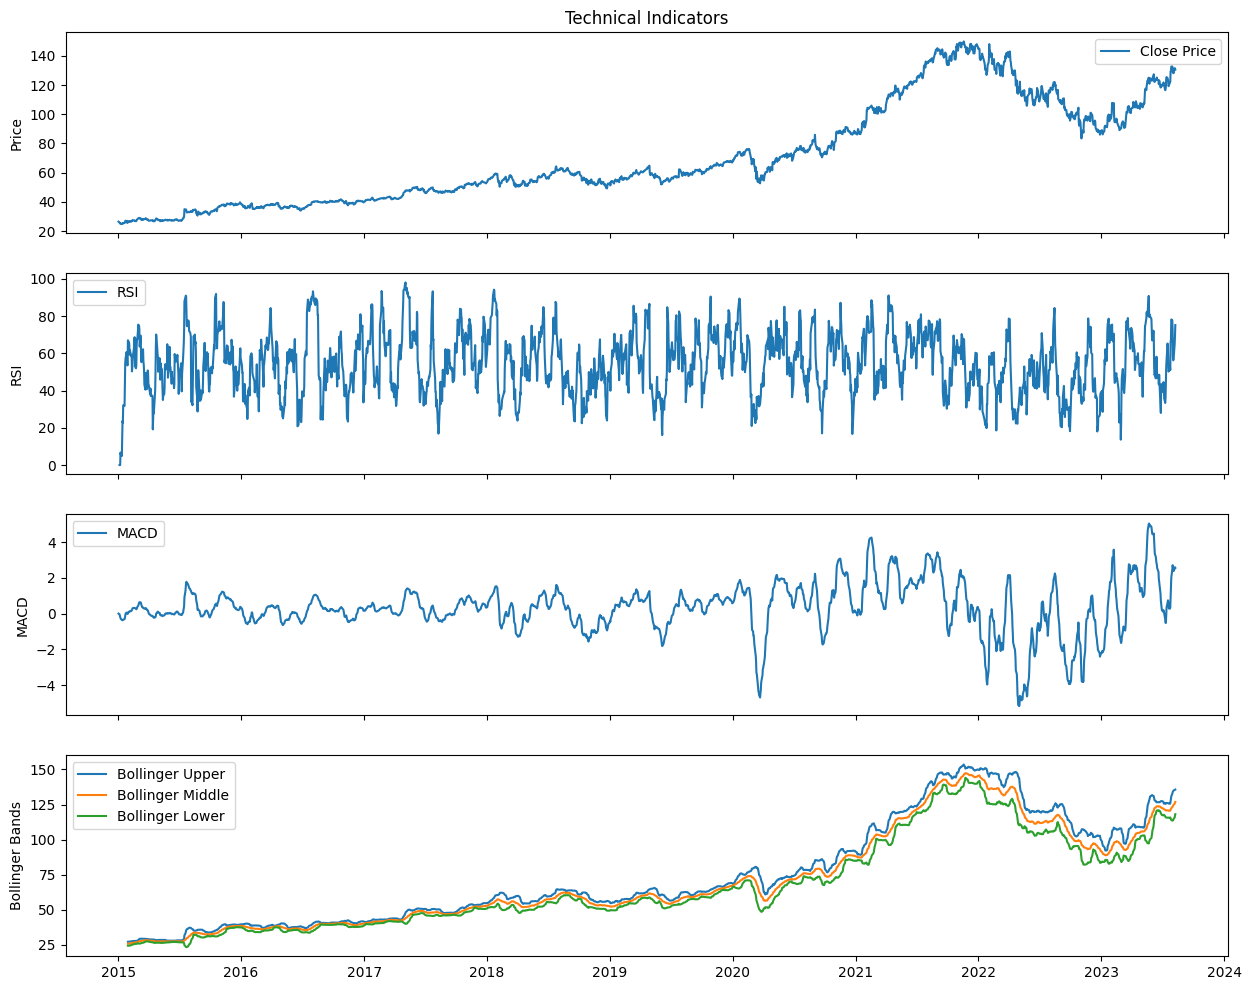

In [14]:
    stock = get_user_stock()
    start_date = '2015-01-01'
    end_date = '2023-12-31'
    seq_length = 60

    data = load_data(stock, start_date, end_date)
    data['Volume'] = yf.download(stock, start=start_date, end=end_date)['Volume']
    scaled_data, x_train, y_train, scaler = preprocess_data(data, seq_length)

    # K-Fold Cross-Validation
    kfold = KFold(n_splits=5, shuffle=True)
    for train_index, test_index in kfold.split(x_train):
        train_X, test_X = x_train[train_index], x_train[test_index]
        train_y, test_y = y_train[train_index], y_train[test_index]
        model = train_model(train_X, train_y)
        prediction = make_predictions(model, test_X, scaler)
        mse = mean_squared_error(test_y, prediction)
        print(f"Mean Squared Error for fold: {mse}")
        
    ma_data = moving_averages(data[['Close']])
    plt.figure(figsize=(15, 6))
    plt.plot(ma_data['Close'], label='Close Price')
    for col in ma_data.columns[1:]:
        plt.plot(ma_data[col], label=col)
    plt.title('Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    # Volume Analysis
    plot_volume(data)

    # Technical Indicators Analysis
    ti_data = compute_technical_indicators(data[['Close']])
    plot_technical_indicators(ti_data)

In [15]:
# Function to predict future prices and provide buy/sell recommendations
def future_price_predictions(model, scaler, last_data, seq_length, forecast_length=7):
    input_data = last_data[-seq_length:, :4].copy()  # Including only 'Open', 'High', 'Low', 'Close'
    future_prices = []
    # Predict future prices
    for _ in range(forecast_length):
        scaled_input = scaler.transform(input_data[-seq_length:])
        scaled_input = scaled_input[:, :-1].reshape((1, seq_length, 3))
        predicted_price = model.predict(scaled_input)[0][0]
        input_data = np.vstack([input_data, [predicted_price, 0, 0, 0]])
        unscaled_prediction = scaler.inverse_transform(
            np.append(scaled_input[0, -1, :], predicted_price).reshape(1, -1)
        )[-1, -1]
        future_prices.append(unscaled_prediction)



    # Determine best days to buy/sell
    buy_days = []
    sell_day = 0
    max_profit = 0

    for i in range(forecast_length):
        for j in range(i + 1, forecast_length):
            profit = future_prices[j] - future_prices[i]
            if profit > max_profit:
                max_profit = profit
                buy_days = [i]
                sell_day = j
            elif profit == max_profit:
                buy_days.append(i)

    # Create a table to display the results
    result_table = pd.DataFrame({
        'Day': [f"Day {i + 1}" for i in range(forecast_length)],
        'Predicted Price': future_prices,
        'Action': ['Buy' if i in buy_days else 'Sell' if i == sell_day else '' for i in range(forecast_length)]
    })

    return result_table

# Future Price Predictions and Buy/Sell Recommendations
recommendations = future_price_predictions(model, scaler, data.values, seq_length)
print("Future Price Predictions and Buy/Sell Recommendations:")
print(recommendations)

1/1 [==============================] - 0s 18ms/step


C:\Users\dev24\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\dev24\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\dev24\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\dev24\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\dev24\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fit

1/1 [==============================] - 0s 19ms/step
Future Price Predictions and Buy/Sell Recommendations:
     Day  Predicted Price Action
0  Day 1       134.894593       
1  Day 2        99.091346       
2  Day 3        64.526808       
3  Day 4        45.100346       
4  Day 5        42.353258    Buy
5  Day 6        43.368596   Sell
6  Day 7        38.303182       


C:\Users\dev24\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\dev24\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
